**Data Preparation**

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "KAGGLE_USERNAME"
os.environ['KAGGLE_KEY'] = "KAGGLE_KEY" 

In [2]:
!kaggle datasets download -d madisona/translated-animals10

 96% 561M/586M [00:03<00:00, 174MB/s]
100% 586M/586M [00:03<00:00, 162MB/s]


In [3]:
!unzip -q translated-animals10.zip -d .

In [4]:
!ls animals10/raw-img/

butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [5]:
cd animals10/raw-img/


/content/animals10/raw-img


In [6]:
!rm -rf elephant  horse  sheep  spider  squirrel

In [7]:
cd /content/


/content


In [8]:
!ls animals10/raw-img/

butterfly  cat	chicken  cow  dog


In [9]:
dataset = os.path.join('/content/animals10/raw-img')

animals5 = os.listdir(dataset)
print(animals5)

['butterfly', 'dog', 'chicken', 'cat', 'cow']


In [10]:
from PIL import Image
total = 0

for i in animals5:
  dir = os.path.join(dataset, i)
  x = len(os.listdir(dir))
  print(i+':', x)
  total = total + x
  
  img_name = os.listdir(dir)
  for y in range(5):
    img_path = os.path.join(dir, img_name[y])
    img = Image.open(img_path)
    print('-',img.size)

print(f'Resolusi gambar tidak seragam.')
print(f'Sampel ada {total} gambar, Lebih dari 10000 sampel/gambar.')

butterfly: 2112
- (300, 300)
- (300, 188)
- (300, 244)
- (300, 225)
- (300, 300)
dog: 4863
- (300, 184)
- (300, 225)
- (177, 300)
- (300, 200)
- (300, 226)
chicken: 3098
- (300, 225)
- (241, 300)
- (300, 232)
- (300, 200)
- (300, 169)
cat: 1668
- (300, 197)
- (300, 169)
- (228, 300)
- (222, 300)
- (300, 199)
cow: 1866
- (300, 180)
- (300, 225)
- (300, 157)
- (300, 200)
- (300, 200)
Resolusi gambar tidak seragam.
Sampel ada 13607 gambar, Lebih dari 10000 sampel/gambar.


**Modeling**

In [11]:
# Dataset dibagi menjadi 80% train set dan 20% test set
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    # brightness_range = [0.2,1.0],
                    rescale = 1./255,
                    rotation_range = 40,
                    horizontal_flip = True,
                    # vertical_flip = True,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split = 0.2                                      
                  )

In [12]:
train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size = (150, 150),
    batch_size = 256,
    # color_mode = "rgb",
    class_mode = 'categorical',
    subset = 'training'
    )

validation_generator = train_datagen.flow_from_directory(
    dataset,
    target_size = (150, 150),
    batch_size = 256,
    class_mode = 'categorical',
    # color_mode = "rgb",
    subset = 'validation'
    )

Found 10888 images belonging to 5 classes.
Found 2719 images belonging to 5 classes.


In [13]:
# Implementasi Sequential, Conv2D Maxpooling Layer menggunakan ResNet (TransferLearning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2


model = tf.keras.models.Sequential([
                                    ResNet152V2(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3))),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(5, activation='softmax')
])
model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 5, 5, 2048)        58331648  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 84,679,173
Trainable params: 26,347,525
Non-trainable params: 58,331,648
___________________________________

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [15]:
#Implementasi Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nTraining dihentikan, nilai akurasi pada training set dan validation set sudah mencapai target yaitu > 92%")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
history = model.fit(train_generator, 
                    epochs = 100, 
                    steps_per_epoch = train_generator.samples // 256,
                    validation_data = validation_generator, 
                    validation_steps = validation_generator.samples // 256,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/100
42/42 [==============================] - 120s 3s/step - loss: 5.8000 - accuracy: 0.7767 - val_loss: 0.4746 - val_accuracy: 0.8996
Epoch 2/100
42/42 [==============================] - 102s 2s/step - loss: 0.5717 - accuracy: 0.8870 - val_loss: 0.3599 - val_accuracy: 0.9141
Epoch 3/100
42/42 [==============================] - 102s 2s/step - loss: 0.4331 - accuracy: 0.8901 - val_loss: 0.3682 - val_accuracy: 0.9137
Epoch 4/100
42/42 [==============================] - 102s 2s/step - loss: 0.3793 - accuracy: 0.8984 - val_loss: 0.3431 - val_accuracy: 0.9047
Epoch 5/100
42/42 [==============================] - 102s 2s/step - loss: 0.4100 - accuracy: 0.8942 - val_loss: 0.2857 - val_accuracy: 0.9164
Epoch 6/100
42/42 [==============================] - 102s 2s/step - loss: 0.3170 - accuracy: 0.9055 - val_loss: 0.3067 - val_accuracy: 0.9074
Epoch 7/100
42/42 [==============================] - 102s 2s/step - loss: 0.2784 - accuracy: 0.9105 - val_loss: 0.2581 - val_accuracy: 0.9219
Epoch 

**Evaluation**

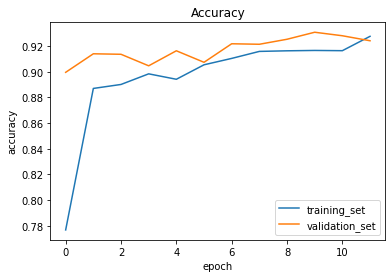

In [17]:
import matplotlib.pyplot as plt
#Plot Accuracy
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'], label='training_set')
plt.plot(history.history['val_accuracy'], label='validation_set')
plt.legend()

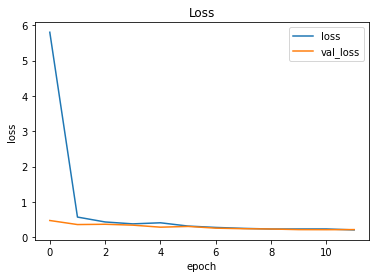

In [18]:
#Plot Loss
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [19]:
# Menyimpan model ke dalam format TF-Lite.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0f8kre69/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root 338204728 Aug 18 14:58 model.tflite
